<a href="https://colab.research.google.com/github/peteryds/Data-Visualization-Homework/blob/main/Analysis_Netflix_Movies_and_TV_Shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# Step 1: Install required packages
# ==========================================
# Installing squarify specifically for the Square Area (Treemap) chart
!pip install pywaffle matplotlib -q

# ==========================================
# Step 2: Import libraries and load the dataset
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import squarify

# Loading the Netflix dataset directly from a raw GitHub URL
# This saves us from having to manually upload the CSV file every time!
url = 'https://raw.githubusercontent.com/peteryds/Data-Visualization-Homework/refs/heads/main/netflix_titles.csv'

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(url)
    print("✅ Data loaded successfully!")
    print(f"📊 Total number of titles in the dataset: {len(df)}")

    # Display the first 3 rows to verify
    display(df.head(3))
except Exception as e:
    print("❌ Error loading the data:", e)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 60.9 MB/s eta 0:00:00
✅ Data loaded successfully!
📊 Total number of titles in the dataset: 8807


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


Titles used in scatterplot: 5653


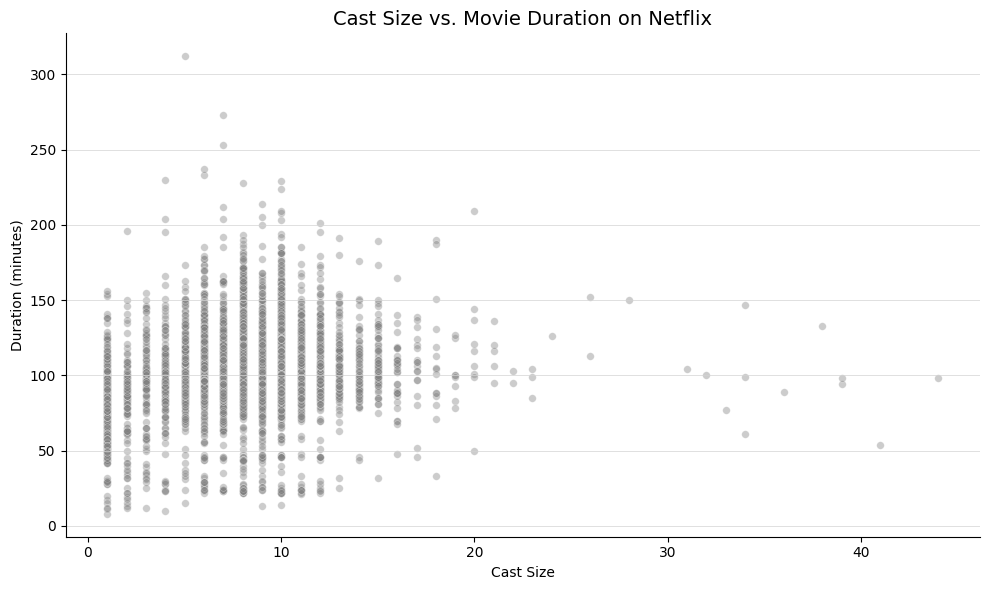

In [ ]:
# ==========================================
# Scatterplot: Cast Size vs Duration (Tre)
# ==========================================

# DONE but could be cleaner

# Make a copy
scatter_df = df.copy()

# ------------------------------------------
# 1. Filter to Movies only
# ------------------------------------------
scatter_df = scatter_df[scatter_df["type"] == "Movie"]

# ------------------------------------------
# 2. Create numeric duration (minutes)
# ------------------------------------------
scatter_df["duration_minutes"] = (
    scatter_df["duration"]
    .str.extract(r'(\d+)')
    .astype(float)
)

# ------------------------------------------
# 3. Count cast members
# ------------------------------------------
scatter_df["cast_size"] = (
    scatter_df["cast"]
    .str.split(",")
    .apply(lambda x: len(x) if isinstance(x, list) else None)
)

# ------------------------------------------
# 4. Drop missing values
# ------------------------------------------
scatter_df = scatter_df.dropna(subset=["duration_minutes", "cast_size"])

print(f"Titles used in scatterplot: {len(scatter_df)}")

# ------------------------------------------
# 5. Create scatterplot
# ------------------------------------------
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=scatter_df,
    x="cast_size",
    y="duration_minutes",
    color="gray",
    alpha=0.4,
    s=30
)

# Minimal styling
plt.title("Cast Size vs. Movie Duration on Netflix", fontsize=14)
plt.xlabel("Cast Size")
plt.ylabel("Duration (minutes)")

# Remove unnecessary spines
sns.despine()

# Light horizontal gridlines only (optional)
plt.grid(axis='y', color='lightgray', linewidth=0.5)
plt.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()


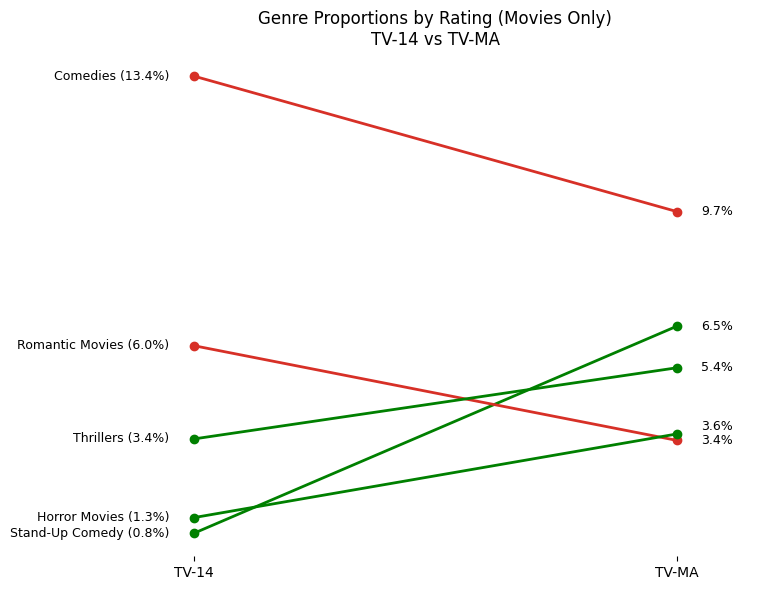

In [ ]:
# ==========================================
# Slopegraph: Genre Proportions by Age Rating
# Comparing TV-MA vs TV-14 (Movies Only)
# ==========================================

# basically DONE

# Make copy
slope_df = df.copy()

# ------------------------------------------
# 1. Filter to Movies + selected ratings
# ------------------------------------------
ratings = ["TV-14", "TV-MA"]

slope_df = slope_df[
    (slope_df["type"] == "Movie") &
    (slope_df["rating"].isin(ratings))
]

# ------------------------------------------
# 2. Split and explode genres
# ------------------------------------------
slope_df["listed_in"] = slope_df["listed_in"].str.split(", ")
slope_df = slope_df.explode("listed_in")

# ------------------------------------------
# 3. Calculate proportions within each rating
# ------------------------------------------
genre_counts = (
    slope_df
    .groupby(["rating", "listed_in"])
    .size()
    .reset_index(name="count")
)

# Calculate total per rating
genre_counts["total"] = genre_counts.groupby("rating")["count"].transform("sum")
genre_counts["proportion"] = genre_counts["count"] / genre_counts["total"]

# ------------------------------------------
# 4. Pivot table format
# ------------------------------------------
pivot = genre_counts.pivot(
    index="listed_in",
    columns="rating",
    values="proportion"
).fillna(0)

# ------------------------------------------
# Select top 5 genres by largest difference
# ------------------------------------------

# dropping these genres because they aren't really "genres", more like
# production methods
pivot = pivot.drop(index="International Movies", errors="ignore")
pivot = pivot.drop(index="Independent Movies", errors="ignore")

pivot["difference"] = abs(pivot[ratings[0]] - pivot[ratings[1]])

pivot = pivot.sort_values("difference", ascending=False).head(5)

pivot = pivot.drop(columns="difference")

# ==========================================
# Cleaner Minimal Slopegraph
# ==========================================

plt.figure(figsize=(8,6))

x_positions = [0, 1]

# Offsets for labels
left_offset = -0.05
right_offset = 0.05
label_shift = 0.002  # small vertical shift for very close labels

# Keep track of previous right label y-value
prev_right_y = None

for genre in pivot.index:
    y_values = pivot.loc[genre].values

    # Determine color based on slope direction
    if y_values[1] > y_values[0]:
        color = 'green'       # more in TV-MA (right side)
    else:
        color = '#d73027'     # reddish, more in TV-14 (left side)

    # Draw line
    plt.plot(x_positions, y_values, marker='o', linewidth=2, color=color)

    # Left label: genre + left percentage
    plt.text(left_offset, y_values[0],
             f"{genre} ({y_values[0]*100:.1f}%)",
             ha='right', va='center', fontsize=9)

    # Right label: nudging if too close
    y_right = y_values[1]
    if prev_right_y is not None and abs(y_right - prev_right_y) < label_shift:
        # If too close, shift current label up or down
        y_right += label_shift
    plt.text(1 + right_offset, y_right,
             f"{y_values[1]*100:.1f}%",
             ha='left', va='center', fontsize=9)

    prev_right_y = y_right  # update for next iteration

# X-axis labels
plt.xticks(x_positions, ratings, fontsize=10)

# Remove all y-axis elements
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, labelleft=False)

plt.xlim(-0.2, 1.2)
plt.grid(False)
plt.title("Genre Proportions by Rating (Movies Only)\nTV-14 vs TV-MA", fontsize=12)
plt.tight_layout()
plt.show()

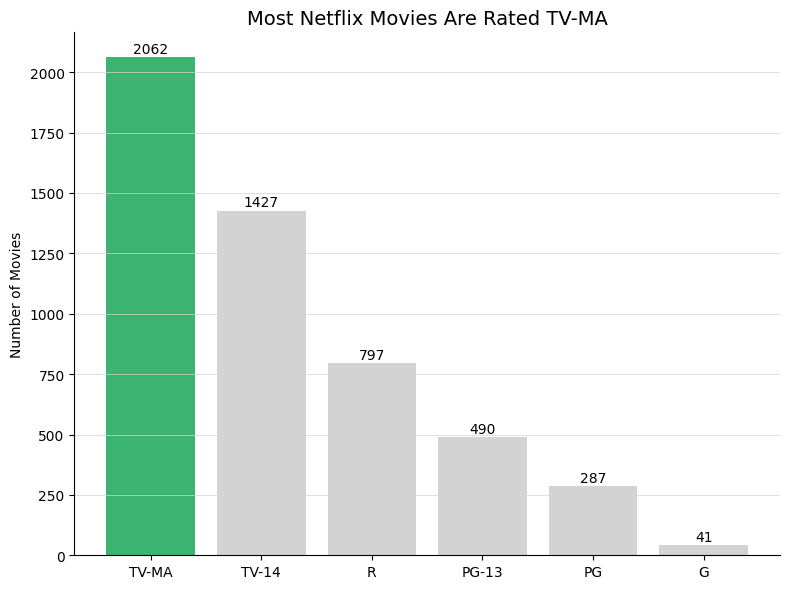

In [ ]:
# ==========================================
# Vertical Bar Graph: Count of Movies by Rating
# ==========================================

# basically DONE

# Subset of ratings to include
ratings_to_include = ["G", "PG", "PG-13", "R", "TV-14", "TV-MA"]

# Filter movies with selected ratings
bar_df = df[
    (df["type"] == "Movie") &
    (df["rating"].isin(ratings_to_include))
]

# Count of titles per rating
rating_counts = bar_df["rating"].value_counts().reindex(ratings_to_include)

# Sort by count (descending)
rating_counts = rating_counts.sort_values(ascending=False)

plt.figure(figsize=(8,6))

# Choose highlight color
highlight = rating_counts.index[0]

colors = [
    "mediumseagreen" if r == highlight else "lightgray"
    for r in rating_counts.index
]

bars = plt.bar(
    rating_counts.index,
    rating_counts.values,
    color=colors
)

# Direct labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 5,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Most Netflix Movies Are Rated " + highlight,
          fontsize=14)

plt.xlabel("")
plt.ylabel("Number of Movies")

# Minimal styling
sns.despine()
plt.grid(axis='y', color='lightgray', linewidth=0.5)
plt.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()


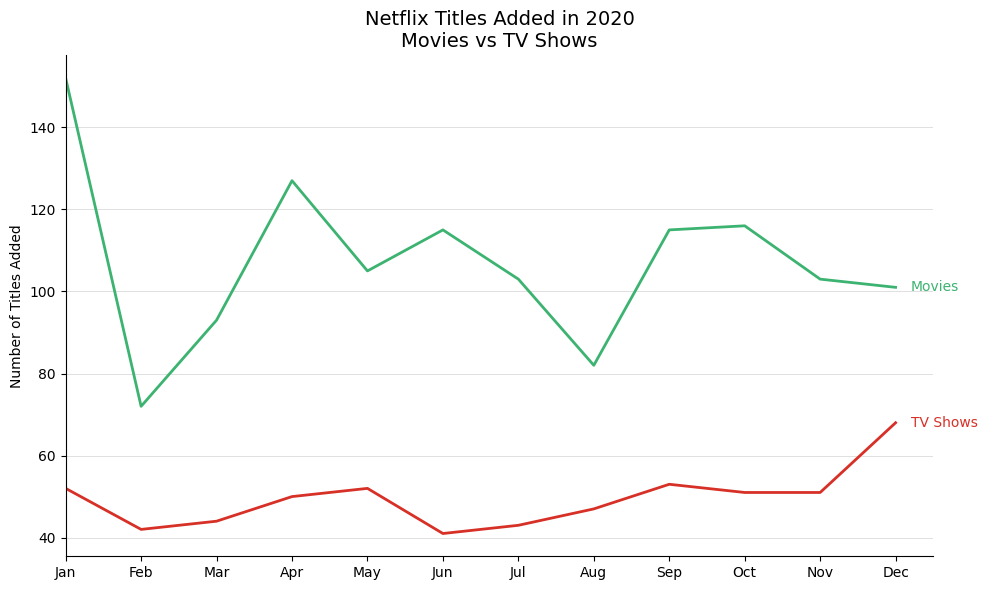

In [ ]:
# ==========================================
# Line Graph: Titles Added in 2020 (Movies vs TV Shows)
# ==========================================

line_df = df.copy()

# Convert date_added to datetime
line_df["date_added"] = pd.to_datetime(line_df["date_added"], errors='coerce')

# Drop missing
df_time = line_df.dropna(subset=["date_added"]).copy()

# Filter to 2020 only
df_time = df_time[df_time["date_added"].dt.year == 2020]

# Extract month number and name
df_time["month"] = df_time["date_added"].dt.month
df_time["month_name"] = df_time["date_added"].dt.strftime("%b")

# Aggregate counts
monthly_counts = (
    df_time
    .groupby(["month", "month_name", "type"])
    .size()
    .reset_index(name="count")
)

# Pivot
pivot_monthly = monthly_counts.pivot(
    index="month",
    columns="type",
    values="count"
).fillna(0)

# Sort by month
pivot_monthly = pivot_monthly.sort_index()

# ------------------------------------------
# Plot (Storytelling with Data style)
# ------------------------------------------

plt.figure(figsize=(10,6))

# Plot lines manually for more control
plt.plot(
    pivot_monthly.index,
    pivot_monthly["Movie"],
    linewidth=2,
    color="mediumseagreen"
)

plt.plot(
    pivot_monthly.index,
    pivot_monthly["TV Show"],
    linewidth=2,
    color="#d73027"
)

# Direct labels at end of lines
plt.text(
    12.2,
    pivot_monthly["Movie"].iloc[-1],
    "Movies",
    color="mediumseagreen",
    va="center"
)

plt.text(
    12.2,
    pivot_monthly["TV Show"].iloc[-1],
    "TV Shows",
    color="#d73027",
    va="center"
)

# Replace numeric x-axis with month names
plt.xticks(
    ticks=range(1,13),
    labels=["Jan","Feb","Mar","Apr","May","Jun",
            "Jul","Aug","Sep","Oct","Nov","Dec"]
)

plt.xlim(1, 12.5)

# Labels
plt.ylabel("Number of Titles Added")
plt.xlabel("")
plt.title("Netflix Titles Added in 2020\nMovies vs TV Shows", fontsize=14)

# Minimal styling
sns.despine()
plt.grid(axis='y', color='lightgray', linewidth=0.5)
plt.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()


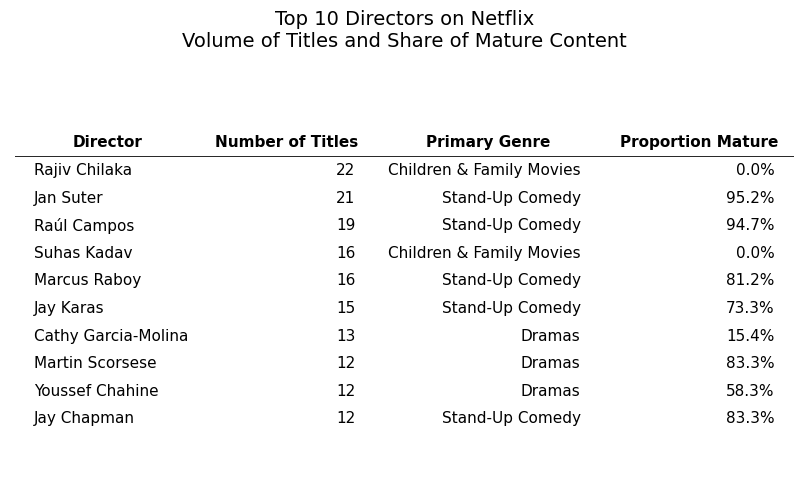

In [ ]:
# ------------------------------------------
# Prepare the data: Top 10 directors with
# proportion mature + primary genre
# ------------------------------------------

directors_df = df.copy()

# Drop missing directors
directors_df = directors_df.dropna(subset=["director"])

# Split + explode directors
directors_df["director"] = directors_df["director"].str.split(", ")
directors_df = directors_df.explode("director")
directors_df["director"] = directors_df["director"].str.strip()

# Count total titles per director
title_counts = directors_df["director"].value_counts()

# Take top 10 directors
top_directors = title_counts.head(10).index.tolist()
top_df = directors_df[directors_df["director"].isin(top_directors)].copy()

# ------------------------------------------
# Proportion mature content
# ------------------------------------------
top_df["is_mature"] = top_df["rating"].isin(["R", "TV-MA"])
mature_prop = top_df.groupby("director")["is_mature"].mean()

# ------------------------------------------
# Primary genre calculation
# ------------------------------------------
genre_df = top_df.copy()
genre_df["listed_in"] = genre_df["listed_in"].str.split(", ")
genre_df = genre_df.explode("listed_in")
genre_df["listed_in"] = genre_df["listed_in"].str.strip()

# removing international movies, since it's not really a "genre"
genre_df = genre_df[genre_df["listed_in"] != "International Movies"]

primary_genre = (
    genre_df
    .groupby(["director", "listed_in"])
    .size()
    .reset_index(name="count")
    .sort_values(["director", "count"], ascending=[True, False])
    .drop_duplicates("director")
    .set_index("director")["listed_in"]
)

# ------------------------------------------
# Final table
# ------------------------------------------
final_table = pd.DataFrame({
    "Director": top_directors,
    "Number of Titles": [title_counts[d] for d in top_directors],
    "Primary Genre": [primary_genre[d] for d in top_directors],
    "Proportion Mature": [
        f"{mature_prop[d]*100:.1f}%" for d in top_directors
    ]
})


# ------------------------------------------
# Create matplotlib table (minimal style)
# ------------------------------------------
fig, ax = plt.subplots(figsize=(9,5))
ax.axis('off')

table = ax.table(
    cellText=final_table.values,
    colLabels=final_table.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.auto_set_column_width(col=list(range(len(final_table.columns))))
table.scale(1, 1.6)

# Remove all borders first
for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("white")
    cell.set_linewidth(0)

# Header styling
for col in range(len(final_table.columns)):
    header_cell = table[(0, col)]
    header_cell.set_text_props(weight='bold')
    header_cell.set_edgecolor("black")
    header_cell.set_linewidth(1.2)
    header_cell.visible_edges = "B"  # only bottom border

# Alignment adjustments
for row in range(1, len(final_table) + 1):
    table[(row, 0)].get_text().set_ha("left")   # Director left-aligned
    table[(row, 1)].get_text().set_ha("right")  # Number right-aligned
    table[(row, 2)].get_text().set_ha("right")  # Proportion right-aligned

plt.title(
    "Top 10 Directors on Netflix\nVolume of Titles and Share of Mature Content",
    fontsize=14,
    pad=25
)

plt.tight_layout()
plt.show()


### Simple Text (Movies vs. TV Shows)
* **Why it fits the data/insight:** We only have one key percentage to highlight (the dominance of movies on Netflix).
* **Book advice applied:** I made the number massive and used a strong blue to draw the eye. The supporting text is made smaller and grey to create a clear visual hierarchy.
* **Python challenges/solutions:**

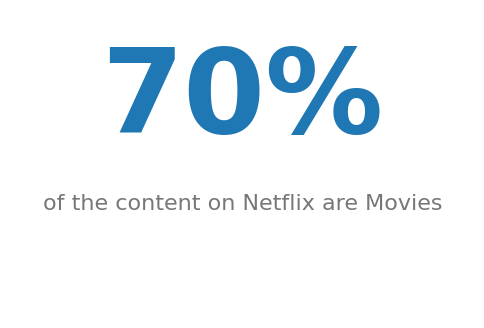

In [ ]:
# Calculate the percentage of movies
pct_movies = (df['type'] == 'Movie').mean() * 100

fig, ax = plt.subplots(figsize=(6, 4))

# Hide all axes and borders (Decluttering)
ax.axis('off')

# Place the massive key number using a professional, calm blue
ax.text(0.5, 0.6, f"{pct_movies:.0f}%", fontsize=85, color='#1F77B4', ha='center', fontweight='black')

# Place the supporting text in a smaller, subtle grey
ax.text(0.5, 0.35, "of the content on Netflix are Movies", fontsize=16, color='#777777', ha='center')

plt.savefig('SimpleText.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap (Content Addition by Month/Year)
* **Why it fits the data/insight:** It shows density over time.
* **Book advice applied:** I avoided rainbow colors and opted for a single-hue sequential colormap (`Blues`).
* **Python challenges/solutions:**

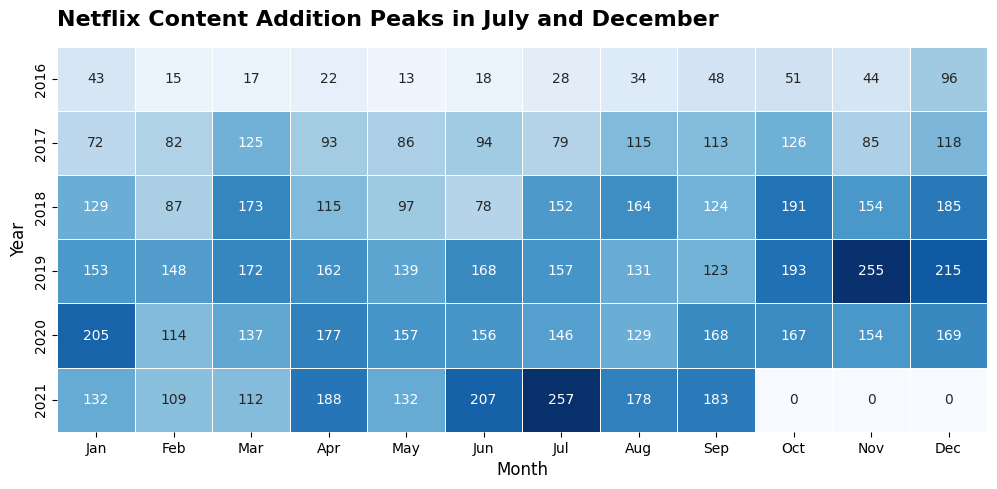

In [ ]:
# Clean the date column and convert to datetime format
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), errors='coerce')

# Filter for recent years (2016 onwards) for a cleaner visual
df_recent = df[df['date_added'].dt.year >= 2016].copy()

# Create a Year vs. Month cross-tabulation matrix
heatmap_data = pd.crosstab(df_recent['date_added'].dt.year, df_recent['date_added'].dt.month)

# Rename columns to month abbreviations
heatmap_data.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(12, 5))

# Use 'Blues' instead of 'Reds' to avoid negative/warning connotations
sns.heatmap(heatmap_data, cmap='Blues', cbar=False, annot=True, fmt='d',
            linewidths=0.5, ax=ax, annot_kws={"size": 10})

ax.set_ylabel('Year', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_title('Netflix Content Addition Peaks in July and December', loc='left', fontsize=16, fontweight='bold', pad=15)
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Waterfall (How the Netflix Catalog is Built)
* **Why it fits the data/insight:** Perfect for showing how individual parts (top countries) sequentially build up to a total whole (the entire catalog).
* **Book advice applied:** I used color purposely to highlight the story. The top 3 countries are colored in a strong blue to draw attention to their massive contribution. "Other" is pushed to the background in light grey, and the "Total" is a neutral dark grey so it anchors the chart.
* **Python challenges/solutions:** Matplotlib has no built-in waterfall chart. I had to manually calculate the cumulative `bottom` parameter for each `plt.bar` to make them stack and float correctly.

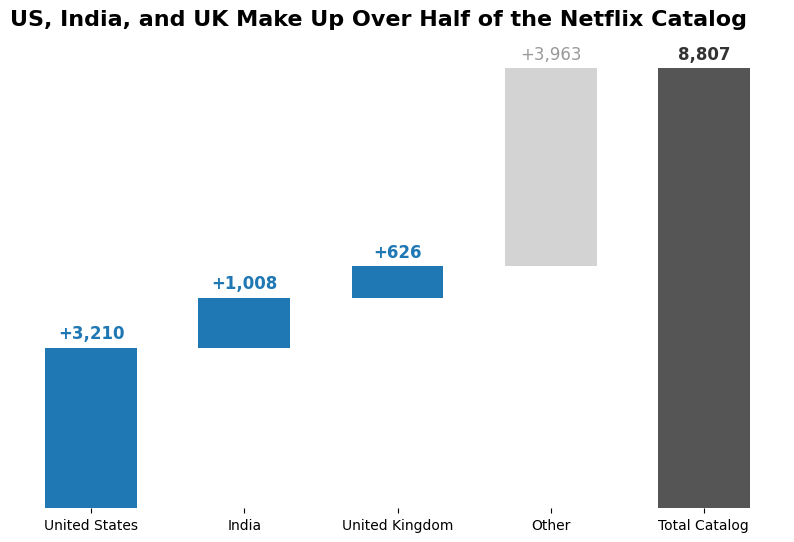

In [ ]:
top_countries = df['country'].str.split(', ').str[0].value_counts()

# Extract values for top 3 countries and calculate the rest
us = top_countries.get('United States', 0)
india = top_countries.get('India', 0)
uk = top_countries.get('United Kingdom', 0)
total = len(df)
others = total - us - india - uk

categories = ['United States', 'India', 'United Kingdom', 'Other', 'Total Catalog']
values = [us, india, uk, others, total]

# Calculate the 'bottom' floating position for each stacked bar
bottoms = [0, us, us + india, us + india + uk, 0]

# Blue for the heroes (Top 3), Light Grey for 'Other', Dark Grey for the 'Total'
colors = ['#1F77B4', '#1F77B4', '#1F77B4', '#D3D3D3', '#555555']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, values, bottom=bottoms, color=colors, width=0.6)

# Hide borders and Y-axis
for spine in ax.spines.values():
    spine.set_visible(False)
ax.get_yaxis().set_visible(False)

# Add text labels on top of each bar
for i, bar in enumerate(bars):
    y_val = bar.get_y() + bar.get_height()
    prefix = "+" if i < len(bars) - 1 else ""

    # Text colors matching the bars for better readability
    if i < 3:
        text_color = '#1F77B4' # Blue for top 3
        weight = 'bold'
    elif i == 3:
        text_color = '#999999' # Grey for others
        weight = 'normal'
    else:
        text_color = '#333333' # Dark grey for total
        weight = 'bold'

    ax.text(bar.get_x() + bar.get_width()/2, y_val + 100,
            f'{prefix}{int(bar.get_height()):,}', ha='center', va='bottom',
            fontsize=12, fontweight=weight, color=text_color)

ax.set_title('US, India, and UK Make Up Over Half of the Netflix Catalog', loc='left', fontsize=16, fontweight='bold', pad=15)
plt.savefig('Waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

### Horizontal Bar (Top 10 Producing Countries)
* **Why it fits the data/insight:** Country names can be long, so a horizontal orientation makes them easy to read without tilting the head.
* **Book advice applied:** I ordered the data from largest to smallest, removed all border spines, and placed data labels directly on the bars to completely eliminate the need for an X-axis.
* **Python challenges/solutions:** The dataset has comma-separated strings for countries (e.g., "United States, India"). I used `.str.split(', ').str[0]` in Pandas to extract just the primary country before counting.

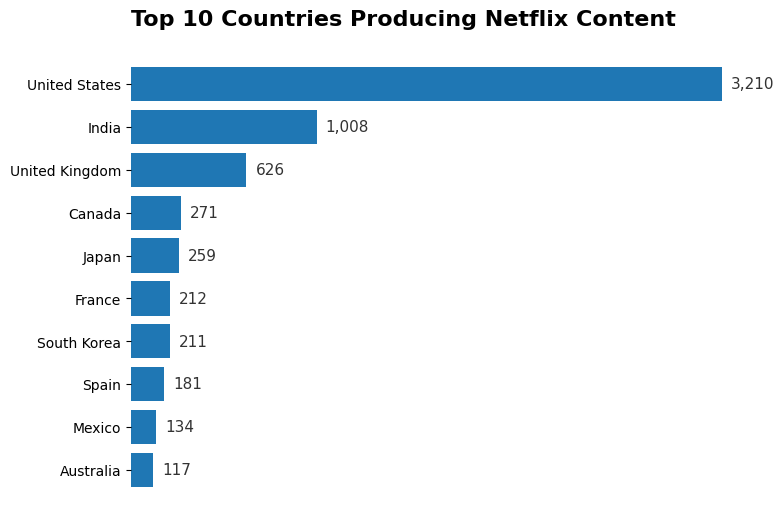

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the primary country and get the top 10
top_countries = df['country'].str.split(', ').str[0].value_counts().head(10).sort_values()

fig, ax = plt.subplots(figsize=(8, 6))

# 🌟 Smart Color Choice: Use a single, consistent professional blue for all bars
bars = ax.barh(top_countries.index, top_countries.values, color='#1F77B4')

# Remove all borders and the X-axis (Chapter 2)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.get_xaxis().set_visible(False)

# Add data labels directly at the end of the bars
for bar in bars:
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
            f"{int(bar.get_width()):,}", va='center', color='#333333', fontsize=11)

ax.set_title('Top 10 Countries Producing Netflix Content', loc='left', fontsize=16, fontweight='bold', pad=15)
plt.savefig('HorizontalBar.png', dpi=300, bbox_inches='tight')
plt.show()

### Square Area
* **Why it fits the data/insight:** A square area graph is perfect for showing a simple part-to-whole relationship (100% total).
* **Book advice applied:**I used a neat 10x10 grid where each icon represents 1% of the catalog.
* **Python challenges/solutions:** Matplotlib doesn't have a built-in square grid chart, so I installed the `pywaffle` library.

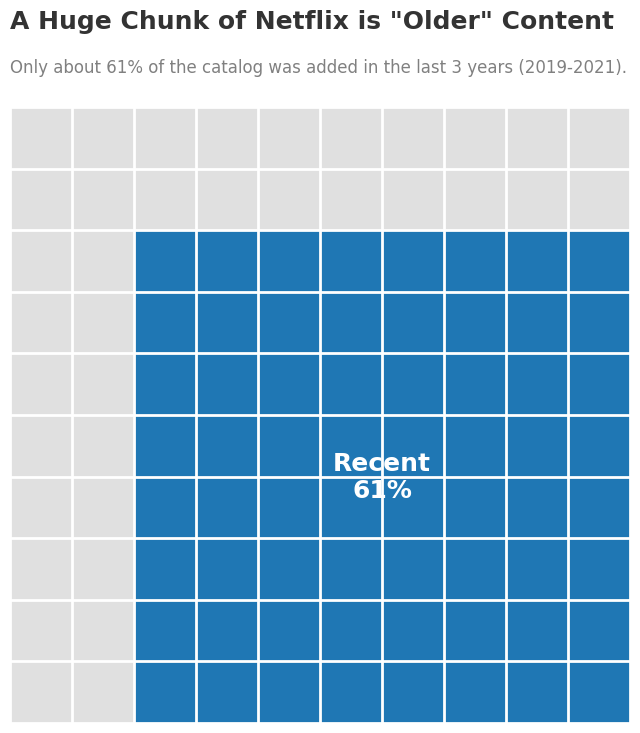

In [ ]:
# Data Processing
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), errors='coerce')
recent_cutoff = 2019
df['freshness'] = df['date_added'].apply(lambda x: 'Recent' if x.year >= recent_cutoff else 'Older')
counts = df['freshness'].value_counts(normalize=True)

actual_recent_pct = counts.get('Recent', 0)
actual_older_pct = counts.get('Older', 0)

# In a 10x10 grid, we need the number of cells to be a perfect square (1, 4, 9, 16, 25, 36, 49, 64, 81, 100)
# to ensure the blue square's border aligns exactly with the 0.1 grid lines.
possible_perfect_squares = [i**2 for i in range(1, 11)]
# We find the perfect square closest to the actual data percentage
target_cells = min(possible_perfect_squares, key=lambda x: abs(x - (actual_recent_pct * 100)))

# Calculate side length in terms of 0.1 units (e.g., 7 cells = 0.7)
side_length = np.sqrt(target_cells) / 10

# Calculate starting position for BOTTOM-RIGHT alignment
small_rect_x = 1.0 - side_length
small_rect_y = 0.0

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Draw the large grey background (Older)
older_rect = patches.Rectangle((0, 0), 1, 1, linewidth=0, facecolor='#E0E0E0', zorder=1)
ax.add_patch(older_rect)

# Draw the small blue square (Recent) - NOW PERFECTLY ALIGNED
recent_rect = patches.Rectangle((small_rect_x, small_rect_y), side_length, side_length,
                                linewidth=0, facecolor='#1F77B4', zorder=2)
ax.add_patch(recent_rect)

# Add the 10x10 Grid Overlay
grid_color = 'white'
grid_linewidth = 2.0
for i in np.arange(0, 1.1, 0.1): # Drawing from 0 to 1.0
    ax.axhline(y=i, color=grid_color, linewidth=grid_linewidth, zorder=3)
    ax.axvline(x=i, color=grid_color, linewidth=grid_linewidth, zorder=3)

# 5. Adding Labels (Adjusted positions to avoid overlap)
# Inside Blue Square
ax.text(small_rect_x + side_length/2, small_rect_y + side_length/2,
        f"Recent\n{actual_recent_pct:.0%}",
        ha='center', va='center', color='white', fontsize=18, fontweight='bold', zorder=4)


# 6. Cleanup & Professional Titles
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Fixed Title and Subtitle overlap
ax.text(0, 1.12, 'A Huge Chunk of Netflix is "Older" Content',
        ha='left', va='bottom', fontsize=18, fontweight='bold', color='#333333')
ax.text(0, 1.05, f"Only about {actual_recent_pct:.0%} of the catalog was added in the last 3 years (2019-2021).",
         ha='left', va='bottom', fontsize=12, color='gray')

plt.savefig('SquareArea_Perfect_Alignment.png', dpi=300, bbox_inches='tight')
plt.show()